In [ ]:
# Set seed for reproducibility
seed = 42

import numpy as np
import random

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import keras_cv
from imblearn.over_sampling import SMOTE

np.random.seed(42)
tf.random.set_seed(42);

# Import dataset

In [ ]:
# Import the dataset without outliers and duplicates
data = np.load("/kaggle/input/augmented-dataset/augmented_dataset.npz")
images = data['images']
labels = data['labels']

In [ ]:
# Normalize images and encode labels
X = (images / 255).astype(np.float32)
y = tfk.utils.to_categorical(labels)

# Split data into training+validation and test sets, maintaining class distribution
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=np.argmax(labels,axis=1))

# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.2, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (8604, 96, 96, 3), y_train shape: (8604, 8)
X_val shape: (2151, 96, 96, 3), y_val shape: (2151, 8)
X_test shape: (1196, 96, 96, 3), y_test shape: (1196, 8)


# Data balancing using SMOTE

In [ ]:
# Reshape the data for SMOTE
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Apply SMOTE
smote = SMOTE(random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train_reshaped, np.argmax(y_train, axis=1))

# Reshape the data back to its original shape
X_train_smote = X_train_smote.reshape(-1, 96, 96, 3)

X_train = X_train_smote
y_train = tfk.utils.to_categorical(y_train_smote)

# Now X_train and y_train contain the oversampled data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (13512, 96, 96, 3), y_train shape: (13512, 8)


# Augmentations

In [ ]:
# Define RandAugment and AugMix layers
randaugment = keras_cv.layers.RandAugment(value_range=(0, 1), augmentations_per_image=3, magnitude=0.5, seed=seed)
augmix = keras_cv.layers.AugMix(value_range=(0, 1), severity=0.3, num_chains=3, alpha=1.0, seed=seed)

# Apply augmentations to training set
X_train_randaugment = randaugment(X_train)
X_train = augmix(X_train_randaugment)

# Apply augmentations to validation set
X_val_randaugment = randaugment(X_val)
X_val = augmix(X_val_randaugment)

# Apply augmentations to test set
X_test_randaugment = randaugment(X_test)
X_test = augmix(X_test_randaugment)

# Network parameters

In [ ]:
# Here we define all relevant parameters for our network
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

epochs = 500
batch_size = 32
learning_rate = 0.0001

dropout_rate = 0.3
l1_lambda = 1e-5
l2_lambda = 1e-4

patience = 20

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

callbacks = [early_stopping]

# Build the model

In [ ]:
# Here we define our model and we pass the parameters

def build_model(
    input_shape = input_shape,
    output_shape = output_shape,
    learning_rate = learning_rate,
    dropout_rate = dropout_rate,
    l1_lambda = l1_lambda,
    l2_lambda = l2_lambda,
    seed = seed
):

    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    batch1 = tfkl.BatchNormalization()(conv1)
    pool1 = tfkl.MaxPooling2D()(batch1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    batch2 = tfkl.BatchNormalization()(conv2)
    pool2 = tfkl.MaxPooling2D()(batch2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    batch3 = tfkl.BatchNormalization()(conv3)
    pool3 = tfkl.MaxPooling2D()(batch3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    batch4 = tfkl.BatchNormalization()(conv4)
    pool4 = tfkl.MaxPooling2D()(batch4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    batch5 = tfkl.BatchNormalization()(conv5)
    pool5 = tfkl.MaxPooling2D()(batch5)

    gap_layer = tfkl.GlobalAveragePooling2D(name='gap')(pool5)

    dropout = tfkl.Dropout(dropout_rate, seed=seed)(gap_layer)
    dense_layer = tfkl.Dense(units=512,
                                  activation='relu',
                                  kernel_initializer=tfk.initializers.HeUniform(seed),
                                  kernel_regularizer=tf.keras.regularizers.L1L2(l1_lambda, l2_lambda),
                                  name='dense_layer')(dropout)

    dropout = tfkl.Dropout(dropout_rate, seed=seed)(dense_layer)
    output_layer = tfkl.Dense(units=output_shape,
                              activation='softmax',
                              kernel_initializer=tfk.initializers.HeUniform(seed),
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1_lambda, l2_lambda),
                              name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics=['accuracy'])

    return model

In [ ]:
# Build model
model = build_model()
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,839,304 (7.02 MB)

 Trainable params: 1,837,320 (7.01 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/500


I0000 00:00:1732300704.911563     118 service.cc:145] XLA service 0x795a0c016d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732300704.911617     118 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732300704.911621     118 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  7/423 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.1212 - loss: 3.6264   

I0000 00:00:1732300712.325459     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2148 - loss: 2.8140

I0000 00:00:1732300724.244757     121 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 8 bytes spill stores, 8 bytes spill loads



423/423 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.2149 - loss: 2.8132 - val_accuracy: 0.3078 - val_loss: 2.0948
Epoch 2/500
423/423 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.3635 - loss: 1.9796 - val_accuracy: 0.4770 - val_loss: 1.6688
Epoch 3/500
423/423 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4664 - loss: 1.7053 - val_accuracy: 0.5281 - val_loss: 1.5447
Epoch 4/500
423/423 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5291 - loss: 1.5243 - val_accuracy: 0.5723 - val_loss: 1.4372
Epoch 5/500
423/423 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5970 - loss: 1.3387 - val_accuracy: 0.5946 - val_loss: 1.3523
Epoch 6/500
423/423 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6605 - loss: 1.1994 - val_accuracy: 0.6053 - val_loss: 1.3120
Epoch 7/500
423/423 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7065 - loss: 1.0666 - val_accuracy: 0.6258 - val_loss: 1.3099
Epoch 8/500
423/423 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7574 - loss: 0.9267 - val_accurac

In [ ]:
model_filename = 'weights.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

# Plot loss and accuracy

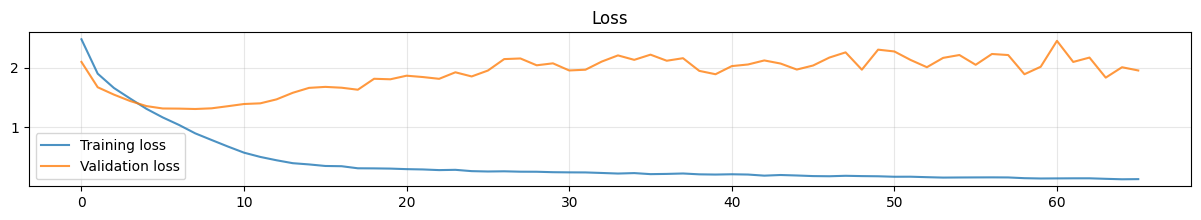

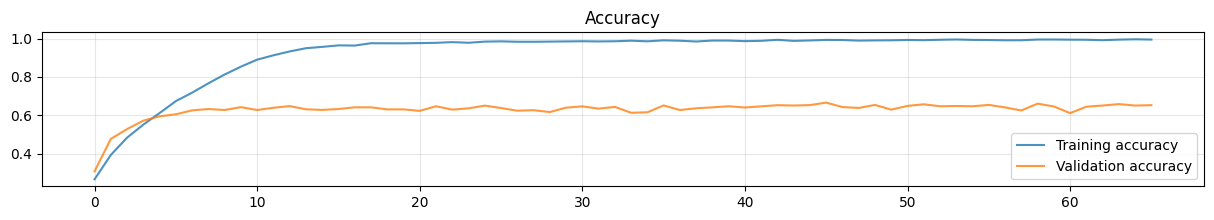

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)

plt.show()

# Make predictions on the test set

In [ ]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

Accuracy score over the test set: 0.6505
Precision score over the test set: 0.6607
Recall score over the test set: 0.6505
F1 score over the test set: 0.6391


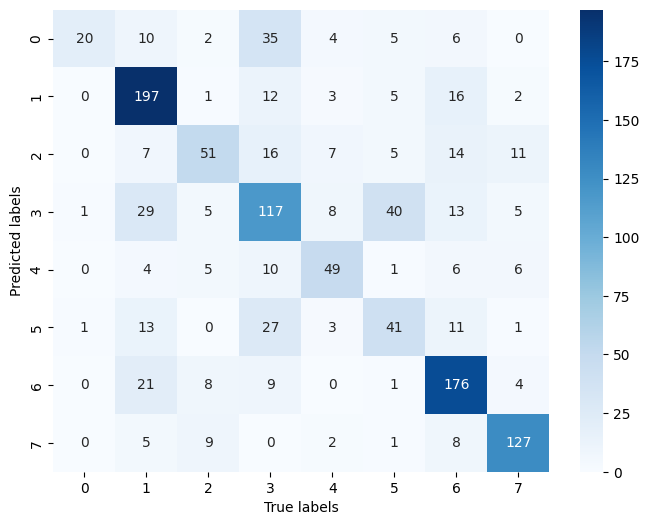

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=['0', '1', '2','3','4','5','6','7'], yticklabels=['0', '1', '2','3','4','5','6','7'], cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()